# TITLE

# Introduction

blah blah blah blah

# Methods

**Loading Libraries**

In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(digest)
library(repr)
library(infer)
library(cowplot)
library(GGally)
library(ISLR)
library(ggplot2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

**Uploading Data and Tidying**

In [2]:
# the data was retreived from: 
data_link <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
data <- read_delim(data_link, ',', col_names = FALSE)

head(data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


In [3]:
# renaming the columns to their variable titles
colnames(data)[1] <- "age"
colnames(data)[2] <- "sex"
colnames(data)[3] <- "chest_pain_type"
colnames(data)[4] <- "resting_bp"
colnames(data)[5] <- "cholestrol"
colnames(data)[6] <- "fasting_blood_sugar"
colnames(data)[7] <- "rest_ecg"
colnames(data)[8] <- "max_heart_rate"
colnames(data)[9] <- "exercise_angina"
colnames(data)[14] <- "hd_diagnosis"

# selecting variables that are of interest to our investigation
data <- select(data, 
                     age,
                     sex,
                     chest_pain_type,
                     resting_bp,
                     cholestrol,
                     fasting_blood_sugar, 
                     rest_ecg,
                     max_heart_rate,
                     exercise_angina,
                     hd_diagnosis)

head(data)

age,sex,chest_pain_type,resting_bp,cholestrol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,hd_diagnosis
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,1,145,233,1,2,150,0,0
67,1,4,160,286,0,2,108,1,2
67,1,4,120,229,0,2,129,1,1
37,1,3,130,250,0,0,187,0,0
41,0,2,130,204,0,2,172,0,0
56,1,2,120,236,0,0,178,0,0


We have downloaded our dataset and tidied it to have descriptive column names. 

In [4]:
data <- data |>
   mutate(sex = recode(sex, "0" = "Female", "1" = "Male"))     

head(data)

age,sex,chest_pain_type,resting_bp,cholestrol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,hd_diagnosis
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,Male,1,145,233,1,2,150,0,0
67,Male,4,160,286,0,2,108,1,2
67,Male,4,120,229,0,2,129,1,1
37,Male,3,130,250,0,0,187,0,0
41,Female,2,130,204,0,2,172,0,0
56,Male,2,120,236,0,0,178,0,0


In addition, as we want to see if resting blood pressure and cholestrol has any correlation with sex, we are changing the values of the column 'sex' to more descriptive labels of 'Male' and 'Female'. From the information about the dataset, we determined that 0 stands for Female and 1 stands for Male.

**Set Seed (will not be changed nor shown after this)**

In [5]:
set.seed(2000) ### DO NOT CHANGE!

To make sure our research is random but also replicable, We set seed one time. Therefore, if others were to replciate our research, they would be able to do so by setting seed at 2000.

**Split our dataset to Training and Testing data**

In [6]:
cleveland_split <- initial_split(data, prop = 0.75, stata = resting_bp)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)
cleveland_split

<Training/Testing/Total>
<227/76/303>

In [7]:
#checking for null/na data in the training data
paste("Number of null values:", sum(map_df(cleveland_training, is.null)))
paste("Number of N/A values:", sum(map_df(cleveland_training, is.na)))

[1] "Number of null values: 0"

[1] "Number of N/A values: 0"

**Initial Assessment**

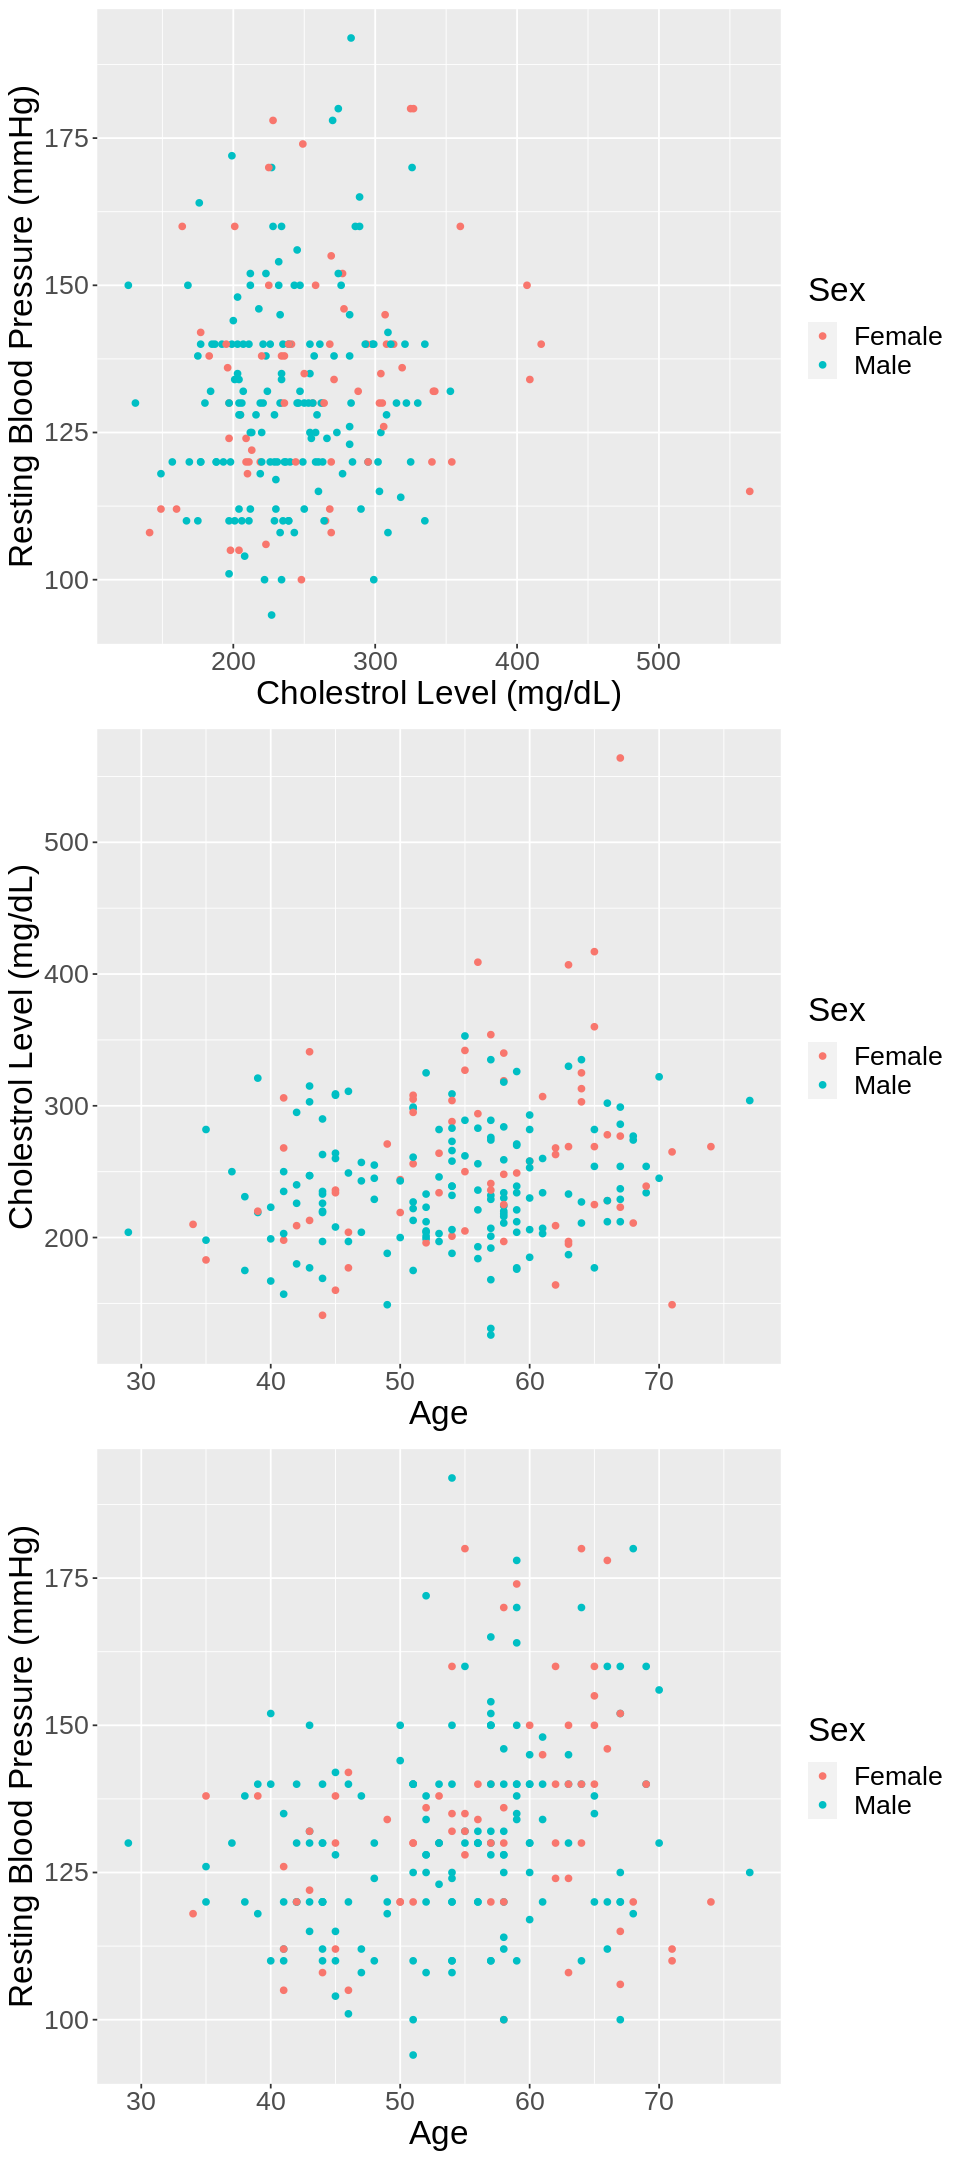

In [8]:
options(repr.plot.width = 8, repr.plot.height = 18)

chol_rbp_plot <- cleveland_training |>
    ggplot(aes(x=cholestrol, y=resting_bp, stat = "identity", color = sex)) +
    geom_point() +
    labs(x="Cholestrol Level (mg/dL)", y="Resting Blood Pressure (mmHg)", color = "Sex") + 
    theme(text = element_text(size=20))


chol_age_plot <- cleveland_training |>
    ggplot(aes(x = age, y = cholestrol,stat = "identity", color = sex)) +
    geom_point() +
    labs(x = "Age", y = "Cholestrol Level (mg/dL)", color = "Sex") + 
    theme(text = element_text(size=20))


age_rbp_plot <- cleveland_training |>
    ggplot(aes(x = age, y = resting_bp, stat = "identity", color = sex)) +
    geom_point() +
    labs(x = "Age", y = "Resting Blood Pressure (mmHg)", color = "Sex") + 
    theme(text = element_text(size=20))


initial_plots <- plot_grid(chol_rbp_plot, chol_age_plot, age_rbp_plot, ncol = 1)
initial_plots

Initial analysis and assessment here

**Model Specification**

In [9]:
# Creating model specification for k-nn
ln_spec <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression")

ln_recipe <- recipe(resting_bp ~ cholestrol + age, data = cleveland_training)

ln_fit <- workflow() |>
            add_recipe(ln_recipe) |>
            add_model(ln_spec) |>
            fit(data = cleveland_training)

ln_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)   cholestrol          age  
  101.47297      0.01958      0.46804  


Looking at our initial graphs, we determined that doing a linear multivariable regression was best.  We do not need to cross-validate nor standardize the data when doing linear regression. Here we created our model specification, recipe and workflow.

**Predicting on the Test Data**

In [10]:
ln_test_results <- ln_fit |>
                predict(cleveland_testing) |>
                bind_cols(cleveland_testing) |>
                metrics(truth = resting_bp, estimate = .pred)

ln_test_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,16.4748019
rsq,standard,0.1561199
mae,standard,12.6052012


Finally, we predict on our testing data to see how our model does. Our model's test error is 16.47 mmHg.

**Extracting Coefficients**

In [36]:
#CODE HERE
coefficients <- ln_fit |>
            extract_fit_parsnip() |>
            tidy()

coefficients

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),101.47296507,7.85515995,12.9180011,6.732507e-29
cholestrol,0.01957794,0.02115009,0.9256669,3.556153e-01
age,0.46804379,0.12833502,3.6470466,3.299287e-04


We can get the coefficients by extracting it first from our workflow using extract_fit_parsnip() and then use tidy() to show our results as a data frame. We did not use pull_workflow_fit() as it was deprecated in workflows 0.2.3.

Since we are using linear regression, we can create an equation for our model:

$Resting\: Blood\: Pressure = 101.47296507 + (0.01958 * cholestrol\:) + (0.46804 * age\:)$


**Calculating RMSE to Assess Goodness of Fit**

In [12]:
ln_rmse <- ln_fit |>
            predict(cleveland_training) |>
            bind_cols(cleveland_training) |>
            metrics(truth = resting_bp, estimate = .pred) |>
            filter(.metric == "rmse") |>
            select(.estimate) |>
            pull()

ln_rmse

[1] 16.91643

Our model predicts on the training set with an error of 16.96 mmHg.

**Calculating RMSPE using the Test Data**

In [13]:
ln_rmspe <- ln_fit |>
            predict(cleveland_testing) |>
            bind_cols(cleveland_testing) |>
            metrics(truth = resting_bp, estimate = .pred) |>
            filter(.metric == "rmse") |>
            select(.estimate) |>
            pull()

ln_rmspe

[1] 16.4748

Our model predicts on the testing set with an error of 16.47 mmHg.

# Results

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



$title

$subtitle
[1] "Effect of Cholestrol level on Resting Blood Pressure"

attr(,"class")
[1] "labels"

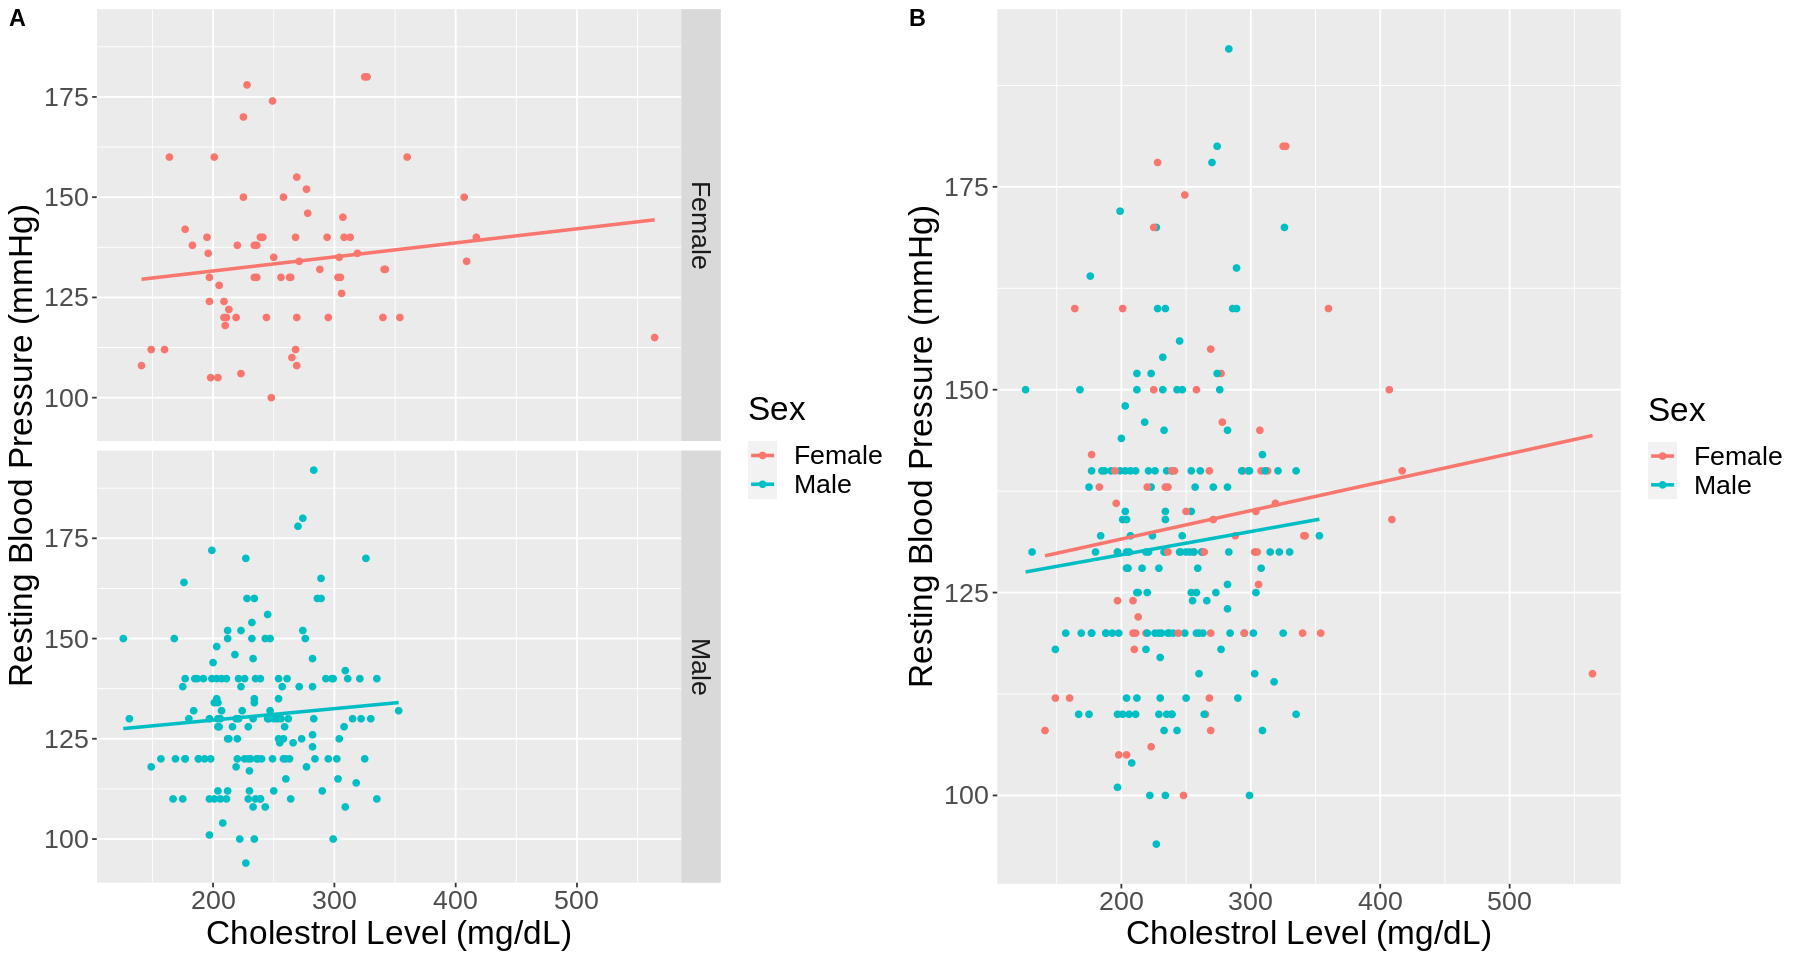

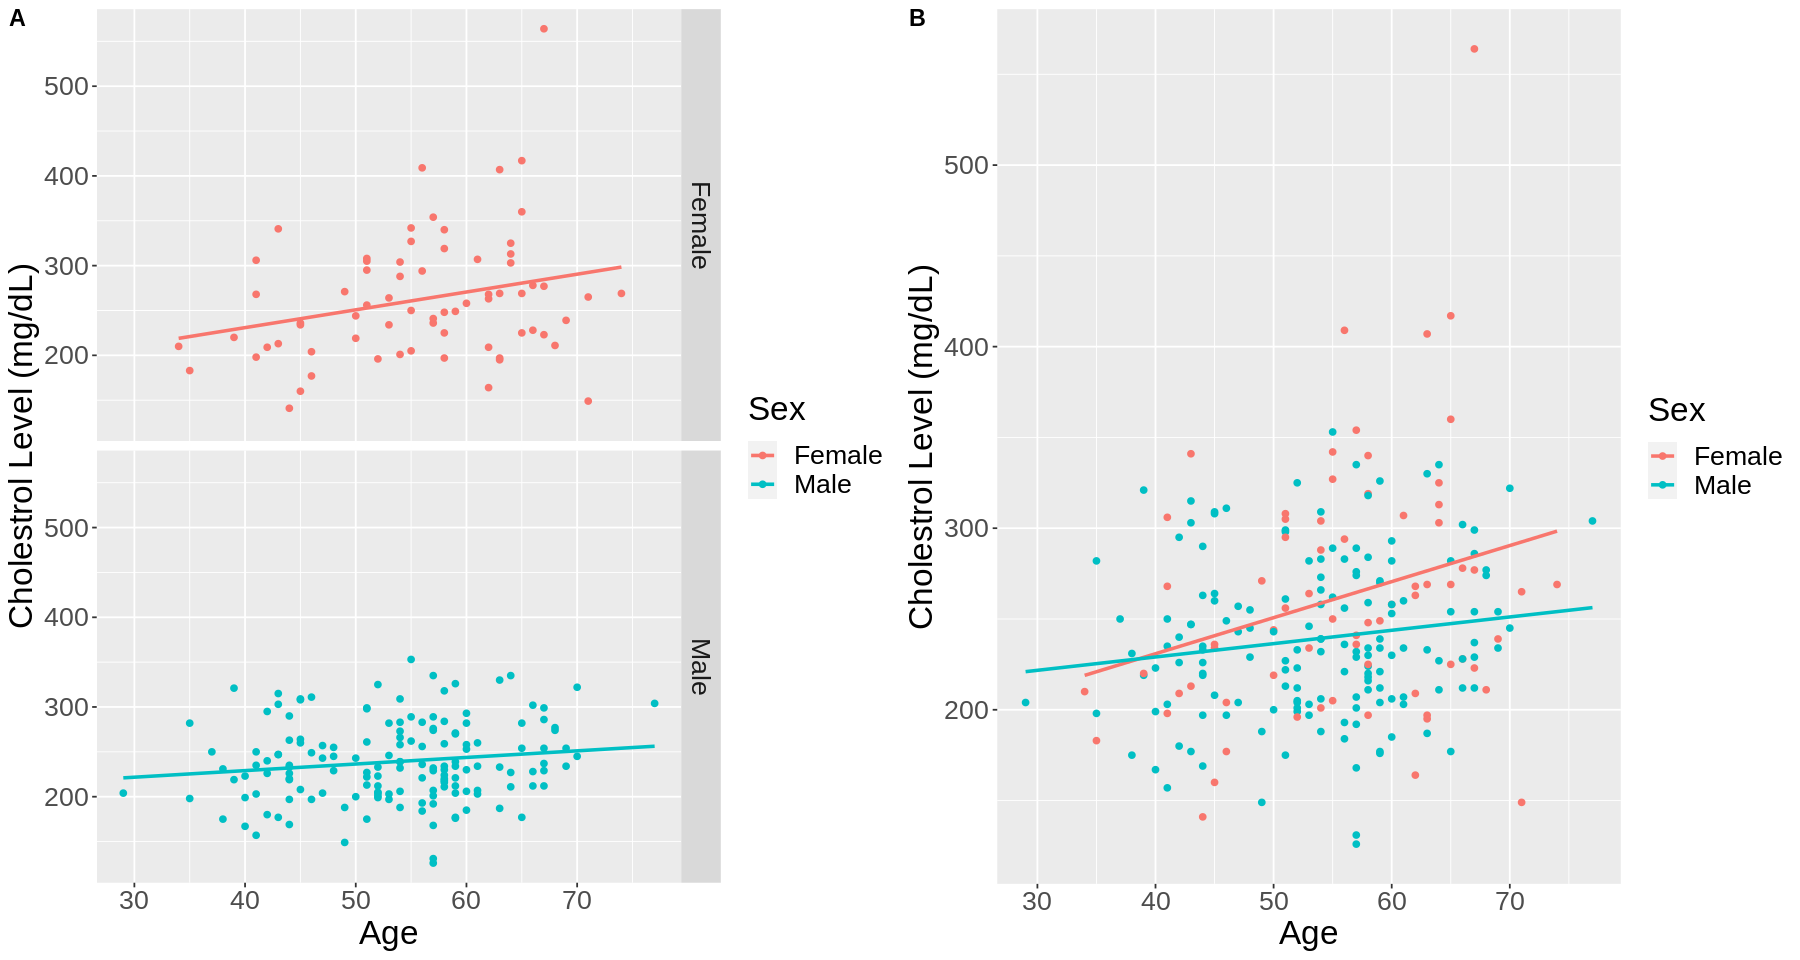

In [41]:
#Visualizing our results 
options(repr.plot.width = 15, repr.plot.height = 8)


Cholestrol_BP_plot1 <- ggplot(cleveland_training, aes(x = cholestrol, y = resting_bp, stat = "identity", color = sex)) +
            geom_point() +
            labs(x = "Cholestrol Level (mg/dL)", y = "Resting Blood Pressure (mmHg)", color = "Sex") +
            geom_smooth(method = "lm", se = FALSE) +
            facet_grid(rows = vars(sex)) +
            theme(text = element_text(size=20))

Cholestrol_BP_plot2 <-  ggplot(cleveland_training, aes(x = cholestrol, y = resting_bp, stat = "identity", color = sex)) +
            geom_point() +
            labs(x = "Cholestrol Level (mg/dL)", y = "Resting Blood Pressure (mmHg)", color = "Sex") +
            geom_smooth(method = "lm", se = FALSE) +
            theme(text = element_text(size=20))


Cholestrol_BP_plot <- plot_grid(Cholestrol_BP_plot1, Cholestrol_BP_plot2, labels = c("A", "B"),
                    ncol = 2, nrow = 1) |>
                   ggtitle("Effect of Cholestrol level on Resting Blood Pressure")



Age_Cholestrol_plot1 <- ggplot(cleveland_training, aes(x = age, y = cholestrol, stat = "identity", color = sex)) +
            geom_point() +
            labs(x = "Age", y = "Cholestrol Level (mg/dL)", color = "Sex") +
            geom_smooth(method = "lm", se = FALSE) +
            facet_grid(rows = vars(sex)) +
            theme(text = element_text(size=20))


Age_Cholestrol_plot2 <- ggplot(cleveland_training, aes(x = age, y = cholestrol, stat = "identity", color = sex)) +
            geom_point() +
            labs(x = "Age", y = "Cholestrol Level (mg/dL)", color = "Sex") +
            geom_smooth(method = "lm", se = FALSE) +
            theme(text = element_text(size=20))

Age_Cholestrol_plot <- plot_grid(Age_Cholestrol_plot1, Age_Cholestrol_plot2, labels = c("A", "B"),
                                ncol = 2, nrow = 1)


Cholestrol_BP_plot
Age_Cholestrol_plot

# Discussion

explanation